# Building powerful image classification models using very little data

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import os
import datetime as dt
import numpy as np
import pandas as pd

In [4]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [56]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import applications
from keras import optimizers

In [6]:
from keras import backend as K
K.set_image_dim_ordering('th')

### VGG16 model

We will only instantiate the convolutional part of the model, everything up to the fully-connected layers. We will then run this model on our training and validation data once, recording the output (the "bottleneck features" from th VGG16 model: the last activation maps before the fully-connected layers) in two numpy arrays. Then we will train a small fully-connected model on top of the stored features.

In [47]:
# build the VGG16 network
vgg16 = applications.VGG16(include_top=False, weights='imagenet', input_shape=(3, 150, 150))

### Data generators and store features

In [8]:
# ideally we want use original VGG image prepossessing mean and no scale
# datagen = ImageDataGenerator(rescale=1., featurewise_center=True)
# datagen.mean = np.array([103.939, 116.779, 123.68], dtype=np.float32).reshape(1, 1, 3)

In [9]:
datagen = ImageDataGenerator(rescale=1. / 255)

In [10]:
batch_size = 16
nb_train_samples = 4000
nb_validation_samples = 800
epochs = 50

In [11]:
generator = datagen.flow_from_directory(
        'data/train',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode=None,     # this means our generator will only yield batches of data, no labels
        shuffle=False)       # our data will be in order, so all first half will be cats, then dogs

# the predict_generator method returns the output of a model, given
# a generator that yields batches of numpy data
bottleneck_features_train = vgg16.predict_generator(generator, nb_train_samples // batch_size)

Found 4000 images belonging to 2 classes.


In [16]:
# save the output as a numpy array
np.save('bottleneck_features_train.npy', bottleneck_features_train)

In [17]:
generator = datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

bottleneck_features_validation = vgg16.predict_generator(generator, nb_validation_samples // batch_size)

Found 800 images belonging to 2 classes.


In [18]:
# save the output as a numpy array
np.save('bottleneck_features_validation.npy', bottleneck_features_validation)

### Build FC top layer

In [26]:
# the features were saved in order, so recreating the labels is easy
train_data = np.load('bottleneck_features_train.npy')
train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

validation_data = np.load('bottleneck_features_validation.npy')
validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

In [27]:
print(train_data.shape)
print(train_labels.shape)
print(validation_data.shape)
print(validation_labels.shape)

(4000, 512, 4, 4)
(4000,)
(800, 512, 4, 4)
(800,)


In [28]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(1, activation='sigmoid'))

In [29]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [30]:
model_history = model.fit(train_data, train_labels,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels))
model.save_weights('bottleneck_fc_model.h5')

Train on 4000 samples, validate on 800 samples
Epoch 1/50
4000/4000 [==============================] - 7s 2ms/step - loss: 0.5920 - acc: 0.7765 - val_loss: 0.3065 - val_acc: 0.8662
Epoch 2/50
4000/4000 [==============================] - 7s 2ms/step - loss: 0.3754 - acc: 0.8515 - val_loss: 0.3302 - val_acc: 0.8900
Epoch 3/50
4000/4000 [==============================] - 7s 2ms/step - loss: 0.3375 - acc: 0.8725 - val_loss: 0.2833 - val_acc: 0.8825
Epoch 4/50
4000/4000 [==============================] - 7s 2ms/step - loss: 0.3164 - acc: 0.8790 - val_loss: 0.2980 - val_acc: 0.8862
Epoch 5/50
4000/4000 [==============================] - 7s 2ms/step - loss: 0.2985 - acc: 0.8862 - val_loss: 0.2810 - val_acc: 0.9050
Epoch 6/50
4000/4000 [==============================] - 7s 2ms/step - loss: 0.2775 - acc: 0.9010 - val_loss: 0.3649 - val_acc: 0.8850
Epoch 7/50
4000/4000 [==============================] - 7s 2ms/step - loss: 0.2745 - acc: 0.8982 - val_loss: 0.3031 - val_acc: 0.8962
Epoch 8/50
4000

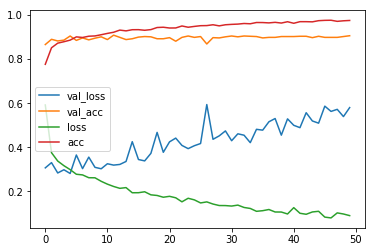

In [31]:
pd.DataFrame(model_history.history).plot();

### Fine tuning the model by training Conv block 5

Note that:

- In order to perform fine-tuning, all layers should start with properly trained weights: for instance you should not slap a randomly initialized fully-connected network on top of a pre-trained convolutional base. This is because the large gradient updates triggered by the randomly initialized weights would wreck the learned weights in the convolutional base. In our case this is why we first train the top-level classifier, and only then start fine-tuning convolutional weights alongside it.
- We choose to only fine-tune the last convolutional block rather than the entire network in order to prevent overfitting, since the entire network would have a very large entropic capacity and thus a strong tendency to overfit. The features learned by low-level convolutional blocks are more general, less abstract than those found higher-up, so it is sensible to keep the first few blocks fixed (more general features) and only fine-tune the last one (more specialized features).
- Fine-tuning should be done with a very slow learning rate, and typically with the SGD optimizer rather than an adaptative learning rate optimizer such as RMSProp. This is to make sure that the magnitude of the updates stays very small, so as not to wreck the previously learned features.

In [53]:
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=train_data.shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.7))
top_model.add(Dense(1, activation='sigmoid'))

# note that it is necessary to start with a fully-trained classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights('bottleneck_fc_model.h5')

# add the model on top of the VGG16 convolutional base
model_full = Model(inputs=vgg16.input, outputs=top_model(vgg16.output))

In [54]:
# set the first 15 layers (up to the last conv block) to non-trainable (weights will not be updated)
for layer in model_full.layers[:15]:
    layer.trainable = False

In [57]:
# compile the model with a SGD/momentum optimizer and a very slow learning rate.
model_full.compile(loss='binary_crossentropy',
    optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
    metrics=['accuracy'])

In [59]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 4000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [60]:
# fine-tune the model
model_history = model_full.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)
model_full.save_weights('fine_tuned_vgg16.h5')

Epoch 1/50
250/250 [==============================] - 1898s 8s/step - loss: 0.4263 - acc: 0.8233 - val_loss: 0.4311 - val_acc: 0.8850
Epoch 2/50
250/250 [==============================] - 1939s 8s/step - loss: 0.2757 - acc: 0.8895 - val_loss: 0.2425 - val_acc: 0.9300
Epoch 3/50
250/250 [==============================] - 1757s 7s/step - loss: 0.2273 - acc: 0.9160 - val_loss: 0.2202 - val_acc: 0.9350
Epoch 4/50
 39/250 [===>..........................] - ETA: 22:15 - loss: 0.2174 - acc: 0.9151

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(model_history.history).plot();